In [59]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import os
import pickle
import re
import torch.nn as nn
import torch.nn.functional as F

from glob import glob
from ffpyplayer.player import MediaPlayer

%matplotlib inline

In [60]:
train_img_glob = glob('data/train/*/*.jpg')
test_img_glob = glob('data/test/*.jpg')
name_glob = glob('data/train/*')

base = os.path.dirname('')
TRAIN_DIR = os.path.join(base + 'data/train')
TEST_DIR = os.path.join(base + 'data/test')

prototxt_file = os.path.join(base + 'data/deploy.prototxt.txt')
caffemodel_file = os.path.join(base + 'data/weights.caffemodel')
embedding_file = os.path.join(base + 'data/openface.nn4.small2.v1.t7')

In [61]:
name_glob

['data/train\\dahyun',
 'data/train\\juri',
 'data/train\\sohee',
 'data/train\\suyun',
 'data/train\\yeonhee',
 'data/train\\yunkyoung']

In [62]:
names = []
int_names = []

one_hot = [0, 1, 2, 3, 4, 5]
for i in one_hot:
    for j in range(10):
        int_names.append(i)

for n in name_glob:
    for i in range(10):
        names.append(n[11:])

In [63]:
face_model = cv2.dnn.readNetFromCaffe(prototxt_file, caffemodel_file)
embedding_model = cv2.dnn.readNetFromTorch(embedding_file)

In [82]:
CONFIDENCE = 0.5
IMG_SIZE = 224
train_extracted_faces = []
test_extracted_faces = []

# training image
for img in train_img_glob:
    print(img)
    a = cv2.imread(img)
    (h,w) = a.shape[:2]
    blob = cv2.dnn.blobFromImage(a, scalefactor=1.0, size=(IMG_SIZE, IMG_SIZE), 
                                 mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
    face_model.setInput(blob)
    detector = face_model.forward()
    
    if len(detector) > 0:
        i = np.argmax(detector[0,0,:,2])
        confidence = detector[0,0,i,2]
        
        if confidence > CONFIDENCE:
            rect = detector[0,0,i,3:7] * np.array([w,h,w,h])
            start_x, start_y, end_x, end_y = rect.astype('int')
            
            face = a[start_y:end_y, start_x:end_x]
            
            if face.size == 0:
                print('no face detected:', img)
                continue
            face = cv2.resize(face, (IMG_SIZE,IMG_SIZE))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            cv2.rectangle(a, (start_x, start_y), (end_x, end_y), (255,255,255), 2)
            
            train_extracted_faces.append(face)
        
        else:
            print('no face detected! confidence below threshold:', img)
    
#     for i in range(0, detector.shape[0]):
#         rect = detector[0, 0, i, 3:7] * np.array([w, h, w, h])
#         (startX, startY, endX, endY) = rect.astype("int")

#         confidence = detector[0, 0, i, 2]
#         if (confidence > 0.5):
#             cv2.rectangle(a, (startX, startY), (endX, endY), (255, 255, 255), 2)
        
#         face = a[startY:endY, startX:endX]
#         resized_face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
#         resized_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2RGB)
        
#         train_extracted_faces.append(resized_face)
        
# # test image
# for img in test_img_glob:
#     a = cv2.imread(img)
#     a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    
#     test_extracted_faces.append(a)
    
# save to disk
train_pickle = {'extracted_faces': train_extracted_faces, 'names': int_names}
# test_pickle = {'extracted_faces': test_extracted_faces}

with open('train_extracted_faces.pickle', 'wb') as f:
    pickle.dump(train_pickle, f)
    
# with open('test_extracted_faces.pickle', 'wb') as f:
#     pickle.dump(test_pickle, f)

data/train\dahyun\dahyun1.jpg
data/train\dahyun\dahyun10.jpg
data/train\dahyun\dahyun2.jpg
data/train\dahyun\dahyun3.jpg
data/train\dahyun\dahyun4.jpg
data/train\dahyun\dahyun5.jpg
data/train\dahyun\dahyun6.jpg
data/train\dahyun\dahyun7.jpg
data/train\dahyun\dahyun8.jpg
data/train\dahyun\dahyun9.jpg
data/train\juri\juri10.jpg
data/train\juri\juri11.jpg
data/train\juri\juri12.jpg
data/train\juri\juri13.jpg
data/train\juri\juri14.jpg
data/train\juri\juri15.jpg
data/train\juri\juri16.jpg
data/train\juri\juri4.jpg
data/train\juri\juri8.jpg
data/train\juri\juri9.jpg
data/train\sohee\sohee1.jpg
data/train\sohee\sohee10.jpg
data/train\sohee\sohee2.jpg
data/train\sohee\sohee3.jpg
data/train\sohee\sohee4.jpg
data/train\sohee\sohee5.jpg
data/train\sohee\sohee6.jpg
data/train\sohee\sohee7.jpg
data/train\sohee\sohee8.jpg
data/train\sohee\sohee9.jpg
data/train\suyun\suyun1.jpg
data/train\suyun\suyun10.jpg
data/train\suyun\suyun2.jpg
data/train\suyun\suyun3.jpg
data/train\suyun\suyun4.jpg
data/train

In [74]:
len(train_extracted_faces)

60

In [69]:
a = cv2.imread('./data/train/sohee/sohee10.jpg')
(h,w) = a.shape[:2]
blob = cv2.dnn.blobFromImage(a, scalefactor=1.0, size=(224, 224), mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
face_model.setInput(blob)
detector = face_model.forward()
    
if len(detector) > 0:
    i = np.argmax(detector[0,0,:,2])
    confidence = detector[0,0,i,2]
        
    if confidence > CONFIDENCE:
        rect = detector[0,0,i,3:7] * np.array([w,h,w,h])
        start_x, start_y, end_x, end_y = rect.astype('int')
            
        face = a[start_y:end_y, start_x:end_x]
        face = cv2.resize(face, (IMG_SIZE,IMG_SIZE))
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        cv2.rectangle(a, (start_x, start_y), (end_x, end_y), (255,255,255), 2)
        
        cv2.imshow('face', face)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    else:
        print("no face detected!")
    

In [54]:
face_cascade = cv2.CascadeClassifier('./data/haarcascade_frontalface_default.xml')

for img in train_img_glob:
    a = cv2.imread(img)
    gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=6)
    for (x,y,w,h) in faces:
        cv2.rectangle(a, (x,y), (x+w,y+h), (255,0,0), 2)

    cv2.imshow('img', a)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

KeyboardInterrupt: 

## Checkpoint

(224, 224, 3)
<class 'numpy.ndarray'>


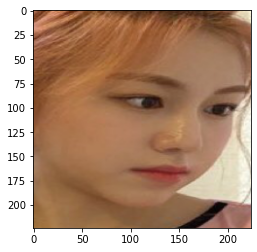

In [49]:
# load the saved extracted faces pickle
with open('train_extracted_faces.pickle', 'rb') as f:
    train_face_loader = pickle.load(f)

# with open('test_extracted_faces.pickle', 'rb') as f:
#     test_face_loader = pickle.load(f)
    
raw_train_data = list(train_face_loader.values())
# raw_test_data = list(test_face_loader.values())

plt.imshow(raw_train_data[0][1])
print(raw_train_data[0][1].shape)
print(type(raw_train_data[0][1]))

In [6]:
from torchvision import datasets, transforms

root = './data'

transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root=root, train=True, transform=transform, download=True)
mnist_val = datasets.MNIST(root=root, train=False, transform=transform, download=True)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=32, num_workers=0, shuffle=True)
mnist_val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=32, num_workers=0, shuffle=True)

In [7]:
print(mnist_train.data.shape)
print(mnist_train.data[0].shape)
print(mnist_train.targets)
print(mnist_train.targets.shape)
print(type(mnist_train.data))

torch.Size([60000, 28, 28])
torch.Size([28, 28])
tensor([5, 0, 4,  ..., 5, 6, 8])
torch.Size([60000])
<class 'torch.Tensor'>


In [8]:
# split between features and labels
train_features = raw_train_data[0]
train_labels = raw_train_data[1]
test_features = raw_test_data[0]

IMG_SIZE = 224
m = len(train_features)
c = 3

x_train = np.asarray(train_features)
x_train_batch_first = x_train.reshape([m,c,IMG_SIZE,IMG_SIZE])
y_train = np.asarray(train_labels)

print(x_train.shape)
print(x_train_batch_first.shape)
print(y_train.shape)

(60, 224, 224, 3)
(60, 3, 224, 224)
(60,)


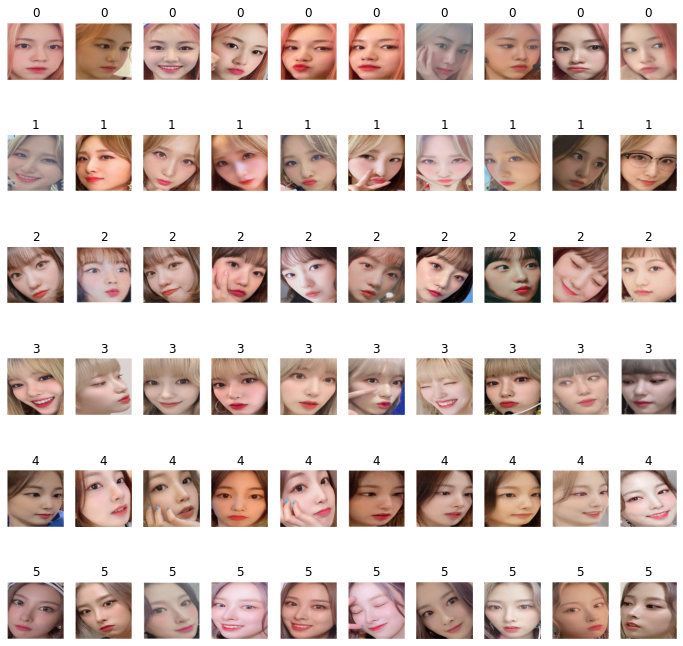

In [9]:
# show all faces for each members
fig, ax = plt.subplots(6, 10, figsize=(12,12))

for (x, y, axi) in zip(train_features, train_labels, ax.flatten()):
#     x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    axi.imshow(x)
    axi.set_title(y)
    
    axi.axis('off')

In [10]:
BATCH_SIZE = 16
NUM_WORKERS = 0

transform = transforms.Compose([transforms.RandomVerticalFlip(0.3),
                                transforms.RandomRotation(30),
#                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                transforms.ToTensor()])

train_data = torch.utils.data.TensorDataset(torch.from_numpy(x_train_batch_first), torch.from_numpy(y_train))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

In [11]:
# temp_x, temp_y = iter(train_loader).next()
# print(temp_x[0].shape)

# fig, ax = plt.subplots(1, 6, figsize=(12,12))
# for (x, y, axi) in zip(temp_x, temp_y, ax.flatten()):
# #     x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
#     axi.imshow(x)
#     axi.set_title(y)
#     axi.axis('off')

In [12]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=256*28*28, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=6)
        
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 256*28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [13]:
gpu_availability = torch.cuda.is_available()
model = Model()

if gpu_availability:
    print('Training using GPU:', torch.cuda.get_device_name(0))
    model = model.cuda()
else:
    print('Training using CPU')

Training using GPU: GeForce RTX 2070 SUPER


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [15]:
def train(epochs, loaders, model, opt, crit, use_cuda, save_path='final_model.pt'):
    
    for i in range(epochs):
        training_loss = 0.0
        
        model.train()
        for batch, (data, lbl) in enumerate(loaders):
            data = data.to(torch.float32)
            lbl = lbl.to(torch.long)
            if use_cuda:
                data, lbl = data.cuda(), lbl.cuda()
                
            opt.zero_grad()
            
            output = model(data)
            loss = crit(output, lbl)
            loss.backward()
            opt.step()
            
            training_loss = training_loss + ((1/(batch+1)) * (loss.data - training_loss))
        
        print("Epoch:", i+1, "| Training Loss:", training_loss)
    
    return model

In [16]:
final_model = train(epochs=30, loaders=train_loader, model=model, opt=optimizer, crit=criterion, use_cuda=gpu_availability)

Epoch: 1 | Training Loss: tensor(145684.2812, device='cuda:0')
Epoch: 2 | Training Loss: tensor(733.1716, device='cuda:0')
Epoch: 3 | Training Loss: tensor(2.0683, device='cuda:0')
Epoch: 4 | Training Loss: tensor(1.7081, device='cuda:0')
Epoch: 5 | Training Loss: tensor(1.6555, device='cuda:0')
Epoch: 6 | Training Loss: tensor(1.4630, device='cuda:0')
Epoch: 7 | Training Loss: tensor(1.3282, device='cuda:0')
Epoch: 8 | Training Loss: tensor(1.2009, device='cuda:0')
Epoch: 9 | Training Loss: tensor(1.0485, device='cuda:0')
Epoch: 10 | Training Loss: tensor(0.9514, device='cuda:0')
Epoch: 11 | Training Loss: tensor(0.8268, device='cuda:0')
Epoch: 12 | Training Loss: tensor(1.4295, device='cuda:0')
Epoch: 13 | Training Loss: tensor(0.6324, device='cuda:0')
Epoch: 14 | Training Loss: tensor(0.5196, device='cuda:0')
Epoch: 15 | Training Loss: tensor(0.3952, device='cuda:0')
Epoch: 16 | Training Loss: tensor(0.3244, device='cuda:0')
Epoch: 17 | Training Loss: tensor(0.2412, device='cuda:0')

In [42]:
def predict(img_path, use_cuda):
    
    IMG_SIZE = 224
    NAMES = ['Dahyun', 'Juri', 'Sohee', 'Suyun', 'Yeonhee', 'Yunkyoung']
    
    test_img = cv2.imread(img_path)
    (h,w) = test_img.shape[:2]
    blob = cv2.dnn.blobFromImage(test_img, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
    face_model.setInput(blob)
    detector = face_model.forward()
    print(detector.shape[2])
    
    for i in range(0, detector.shape[1]):
        rect = detector[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = rect.astype("int")

        confidence = detector[0, 0, i, 2]
        if (confidence > 0.5):
            cv2.rectangle(test_img, (startX, startY), (endX, endY), (255, 255, 255), 2)
        
        face = test_img[startY:endY, startX:endX]
        resized_face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
    
    
    resized_face = np.expand_dims(resized_face, axis=0)
    print(resized_face.shape)
    
    m = 1
    c = 3
    resized_face = np.reshape(resized_face, [m, c, IMG_SIZE, IMG_SIZE])
    print(resized_face.shape)
    
    test_data = torch.Tensor(resized_face)
    
    model.eval()
    
    if use_cuda:
        test_data = test_data.cuda()
        
    output = model(test_data)
    print(output[0])
    pred = np.argmax(output.cpu().detach())
    print(pred)
    
    text = "{}: {:.2f}%".format(NAMES[pred], output[0][pred]/sum(output[0]) * 100)
    print(text)
    cv2.putText(test_img, text, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    cv2.imshow('Prediction', test_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

In [43]:
predict('./data/twitter/RCPC_members-1226142423287394305-20200208_205508-img3.jpg', use_cuda=gpu_availability)

130
(1, 224, 224, 3)
(1, 3, 224, 224)
tensor([-2.6687,  6.3436, 10.5038,  6.8802,  9.1396,  1.2826], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(2)
Sohee: 33.37%


In [25]:
# def play_video(path):
#     frame_name = 'Video'
#     vid = cv2.VideoCapture(path)
# #     audio = MediaPlayer(path)
    
#     cv2.namedWindow(frame_name, cv2.WND_PROP_FULLSCREEN)
#     cv2.setWindowProperty(frame_name, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    
#     fps = vid.get(cv2.CAP_PROP_FPS)
#     print('Video fps:', fps)
    
#     while vid.isOpened():
#         ret, frame = vid.read()
# #         audio_frame, val = audio.get_frame()
        
#         gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#         face = face_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3, minSize=(30,30), maxSize=(200,200))
#         for (x, y, w, h) in face:
#             cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
#         if not ret:
#             print('End of video...')
#             break
#         cv2.imshow(frame_name, frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
# #         if val != 'eof' and audio_frame is not None:
# #             img, t = audio_frame
        
#     vid.release()
#     cv2.destroyAllWindows()

In [ ]:
# play_video('data/rcpc_loveisover_mcountdown.webm')